# <center>Minimum Transformation Method
## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika



##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in TS space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

TO DO: Run the ACCESS code with NO constraints as below but less BSP bins: Floor is 19 patches, do 2^4 - HAS TO BE ZERO
Also: Check the weird white space
Also: Do 1D problem but with regions
Expand the sensitivity space to include - weights, resolution, forcing (i.e., none or yes), connectivity, scaling factor

weights: might not have to use log of area with 16 bins, or no area weight at all? 
scaling factor: do wth STD ratios and the existing factor

resolution: 16



## A) Pre-processing

### i) Load necessary modules for computation

In [1]:
## Module to run the minimisation
from WM_Methods import MTM
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Specify font properties for plots
# from matplotlib import rc
# font = {'family' : 'DejaVu Sans',
#         'weight' : 'normal',
#         'size'   : 16}

# rc('font', **font)

### ii) Define key parameters

In [2]:
# If Surface fluxes are available
SF = False
HF_offset = 0 #-5 #W/m2
FW_offset = 0 #0.5 #mm/day
tree_depth = 4

In [3]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)
range_yrs = init_late-init_early+1

-----------
## B) Load Data



The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [4]:
%%time
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*ACCESS_*%i_bins_*.nc' %(tree_depth))

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ACCESS_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-273.15
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ACCESS_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ACCESS_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values


CPU times: user 583 ms, sys: 59.6 ms, total: 642 ms
Wall time: 815 ms


In [5]:
ACCESS_TS_dist_hist = xr.open_mfdataset('~/UNSW_work/MIN_MIX_FINAL/TS_Sfunction/TS_distribution_ACCESS_CM2_hist.nc')
tbins = ACCESS_TS_dist_hist.tbins.values
sbins = ACCESS_TS_dist_hist.sbins.values

In [6]:
dtbins = np.diff(tbins)[0]
dsbins = np.diff(sbins)[0]

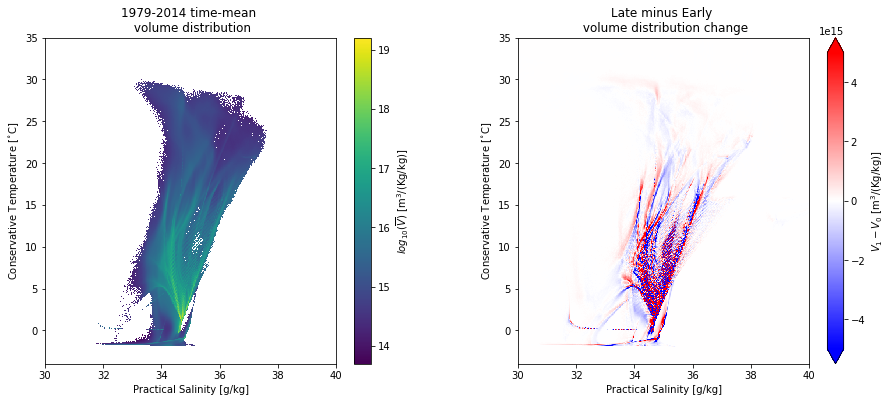

In [7]:
fig, axs = plt.subplots(1,2, figsize=(7.5*2,2.5*1.2*2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.3)
axs = axs.ravel()

(np.log10(ACCESS_TS_dist_hist.TS_distribution/(dsbins*dtbins)).mean('time')).plot(ax=axs[0], cmap=plt.cm.viridis, cbar_kwargs={'label': "$log_{10}(\overline{V})$ [m$^3$/(Kg/kg)]"})
((((ACCESS_TS_dist_hist.TS_distribution.sel(time=slice('2006-01-01', '2014-12-31'))/(dsbins*dtbins)).mean('time')) - \
         (ACCESS_TS_dist_hist.TS_distribution.sel(time=slice('1979-01-01', '1987-12-31'))/(dsbins*dtbins)).mean('time'))).plot(ax=axs[1],cmap=plt.cm.bwr, cbar_kwargs={'label': "$V_1-V_0$ [m$^3$/(Kg/kg)]"}, vmin=-5e15, vmax=5e15)

for i in range(2):
    # axs[i].set_xlim(30,40)
    # axs[i].set_ylim(-3,35)
    axs[i].set_ylabel('Conservative Temperature [$^{\circ}$C]')
    axs[i].set_xlabel('Practical Salinity [g/kg]')
axs[0].set_title('1979-2014 time-mean \n volume distribution')
axs[1].set_title('Late minus Early \n volume distribution change')
plt.savefig('ACCESS_CM2_hist_TS_dist_summary.png', dpi=300, bbox_inches='tight')
plt.show()



##### Calculate the area weight scale (1/std(T), 1/std(S))

In [8]:
T_nonan = ACCESS_TS_dist_hist.tbins.expand_dims(dim={"sbins": ACCESS_TS_dist_hist.sbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"sbins": ACCESS_TS_dist_hist.sbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
S_nonan = ACCESS_TS_dist_hist.sbins.expand_dims(dim={"tbins": ACCESS_TS_dist_hist.tbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"tbins": ACCESS_TS_dist_hist.tbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)

T_nonan_std = T_nonan.std(skipna=True).values
S_nonan_std = S_nonan.std(skipna=True).values

T_scale = 1/T_nonan_std
S_scale = 1/S_nonan_std

##### Calculate Early partitions for illustration

In [9]:
%%time
Part_early.load()
V_early_vals = np.log10(V_early.values)
V_early_vals[~np.isfinite(V_early_vals)] = 0

mask_EN4_xr = xr.open_mfdataset('../Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_0*')
lats = data.lat.values
lons = data.lon.values

mask_EN4[mask_EN4==0] = np.nan


CPU times: user 1.36 s, sys: 133 ms, total: 1.5 s
Wall time: 1.6 s


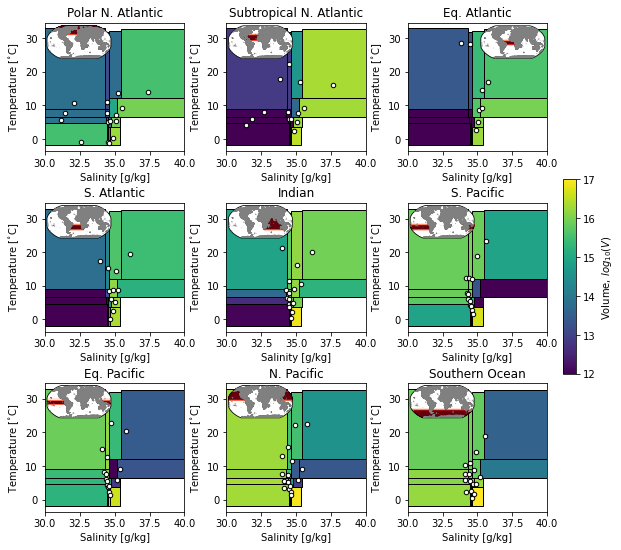

In [10]:

fig, axs = plt.subplots(3,3, figsize=(7.5*1.2,7.5*1.2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0.3)
axs = axs.ravel()

minv, maxv = 12,17

cmap = plt.cm.viridis
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

axis_locs = [[0.1275, 0.825, 0.1, 0.05],
[0.4075, 0.825, 0.1, 0.05],
[0.797, 0.825, 0.1, 0.05],
[0.1275, 0.5475, 0.1, 0.05],
[0.4075, 0.5475, 0.1, 0.05],
[0.688, 0.5475, 0.1, 0.05],
[0.1275, 0.27, 0.1, 0.05],
[0.4075, 0.27, 0.1, 0.05],
[0.688, 0.27, 0.1, 0.05]]

for i in range(Basins.size):
    axins = fig.add_axes(axis_locs[i], projection = ccrs.Robinson())
    axins.pcolormesh(lons, lats, mask_EN4[i,:,:], transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap=plt.cm.Reds)
    axins.add_feature(cfeature.LAND.with_scale('50m'), zorder=100, color='grey', edgecolor=None)
    axins.coastlines()
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_extent([-180,180, -83,90], crs=ccrs.PlateCarree())

for j in range(Basins.size):
    for i in range(2**tree_depth):
        axs[j].add_patch(patches.Rectangle((Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,2]-273.15), \
            Part_early.isel(Basin=j)[i,1]-Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,3]-Part_early.isel(Basin=j)[i,2], ec='black', facecolor=cmap(norm((V_early_vals[j,i]))), zorder=-1000))
    axs[j].scatter(SA_early.isel(Basin=j).values.flatten(),CT_early.isel(Basin=j).values.flatten(),20, marker='o', color='white', ec='black')
    axs[j].set_xlim(30,40)
    axs[j].set_title(Basins[j])
    axs[j].set_ylabel('Temperature [$^{\circ}$C]')
    axs[j].set_xlabel('Salinity [g/kg]')

cax1 = fig.add_axes([0.925, 0.338, 0.02, 0.3])
m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
m.set_clim(minv, maxv)
cbar1 = fig.colorbar(m, cax=cax1)
cbar1.set_label('Volume, $log_{10}(V)$')
plt.savefig('../Figures/BSP_binned_volumes_ACCESS.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s

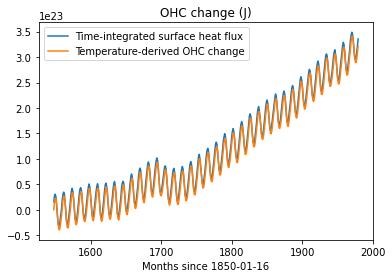

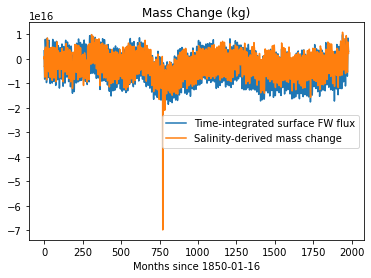

In [12]:
## Check for heat and salt closure
## HEAT
((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth'))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth').isel(Time=Early_period[0]))).plot(label='Temperature-derived OHC change')
plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
plt.show()
## SALT
(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,120)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
plt.show()

In [13]:
## Load SF data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=-1))\
        -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
    WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=-1)\
         -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg

    time = ACCESS_BSP_data.Time.values

In [14]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])



Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [15]:
## IF SURFACE FLUXES ARE PROVIDED -- add here ##
if SF:
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0


In [16]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)

tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [17]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 144


---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [18]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
# connectivity_array = np.ones((Basins.size,Basins.size))

connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [19]:


# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint
transport_array = np.zeros((Basins.size,Basins.size))

transport_array[4,:] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
transport_array[6,:] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

d = {Basins[0]: transport_array.T[0,:],\
    Basins[1]: transport_array.T[1,:],\
    Basins[2]: transport_array.T[2,:],\
    Basins[3]: transport_array.T[3,:],\
    Basins[4]: transport_array.T[4,:],\
    Basins[5]: transport_array.T[5,:],\
    Basins[6]: transport_array.T[6,:],\
    Basins[7]: transport_array.T[7,:],\
    Basins[8]: transport_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Ocean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

# connected = np.ones((Vol_1.size, Vol_1.size)) ## For all connections case

trans_big = np.zeros((Vol_1.size, Vol_1.size))
connected = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        trans_big[i,j] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1 ## For NO DOCKING case
            ## UNCOMMENT BELOW IF YOU WANT DOCKING AGAIN
                # if Basin_names[i] == Basin_names[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
                # elif S_start[i]==S_start[j] and T_start[i]==T_start[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

# constraints = connected # Shape: An [N x N] matrix

transport = trans_big  # Shape: An [N x N] matrix

  0%|          | 0/144 [00:00<?, ?it/s]

### ii) Define Weights
##### a) Late Water masses

In [21]:
## We create a weight matrix
# For sqrt(1/Area)
A_2_modified = A_2.copy()
A_2_modified[A_2_modified==0] = 10**2.02 # this is the lowest I can make it for tree_depth=4 without it breaking

print(np.nanmin(A_2_modified[A_2_modified>0]), 10**2.02)

area_weight = np.sqrt(areanorming/A_2_modified)

area_cons = A_2/A_2-1
area_cons[np.isnan(area_cons)] = 1

## For log(Area)
# area_weight = np.log10(areanorming)/(np.log10(A_2))
# area_weight[area_weight==0] = 100

weights = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix
hard_area = np.stack((area_cons,area_cons), axis=0)

104.71285480508996 104.71285480508996


##### b) Early Water Masses

In [22]:
## We create a weight matrix
# For sqrt(1/Area)
A_1_modified = A_1.copy()
A_1_modified[A_1_modified==0] = 10**-10 # this is the lowest I can make it for tree_depth=4 without it breaking

print(np.nanmin(A_1_modified[A_1_modified>0]), 10**2.02)

area_weight = np.sqrt(areanorming/A_1_modified)

area_cons = A_1/A_1-1
area_cons[np.isnan(area_cons)] = 1

## For log(Area)
# area_weight = np.log10(areanorming)/(np.log10(A_2))
# area_weight[area_weight==0] = 100

weights2 = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix
hard_area = np.stack((area_cons,area_cons), axis=0)

1e-10 104.71285480508996


-----------------
## D) Run Optimisation

In [23]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
# threshold = 1*(range_yrs*yr2sec/volnorming) #xxx m/s
# if SF:
#     trans_val = -15*(10**6*(range_yrs*yr2sec/volnorming)) # xxx Sv
# else:
#     trans_val = 0

## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
#                                 trans = [transport,trans_val], Asection = [connected_Asection,threshold], weights=weights, hard_area = hard_area)
result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)#, hard_area = hard_area)

g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
G = result['G'] ## An [ix] matrix of transports between WMs

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 15 12:50:39 PM: Your problem has 6912 variables, 2 constraints, and 0 parameters.
(CVXPY) May 15 12:50:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 12:50:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 12:50:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 12:50:39 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 15 12:50:39 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [24]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

In [25]:

import cvxpy as cp

cons_matrix = connected

## Define matrices for the linear optimisation

N = volumes.shape[-1]
M = tracers.shape[1]

nofaces = np.count_nonzero(cons_matrix)

C1_connec=np.zeros((N,int(nofaces)))
C2_connec=np.zeros((N,int(nofaces)))
# Also make T and S matrix with the T(k,i) the temp of the ith early WM
Tmatrix=np.zeros((N,int(nofaces)))
Smatrix=np.zeros((N,int(nofaces)))
if M>2:
    trac_matrix = np.zeros((M-2,N,int(nofaces)))
ix=0
for i in (range(N)):
    for j in range(N):
        if cons_matrix[i,j]>0:
            C1_connec[i,ix] = cons_matrix[i,j] # vertex ix connects from WM i
            C2_connec[j,ix] = cons_matrix[i,j] # vertex ix connects to WM j
            Tmatrix[j,ix] = tracers[0,1,i] #vertex ix brings temp of WM i to WM j
            Smatrix[j,ix] = tracers[0,0,i] #vertex ix brings temp of WM i to WM j
            if M>2:
                trac_matrix[:,j,ix] = tracers[0,2:,i]*weights[2:,i] #vertex ix brings temp of WM i to WM j
            ix=ix+1

C = np.concatenate((C1_connec,C2_connec),axis=0)

d = np.concatenate((volumes[0,:],volumes[1,:]),axis=0)

A_T = np.zeros_like(Tmatrix)
A_S = np.zeros_like(Tmatrix)
for i in range(int(nofaces)):
    A_T[:,i] = Tmatrix[:,i]*weights[1,:]
    A_S[:,i] = Smatrix[:,i]*weights[0,:]

A = np.concatenate((A_T,A_S),axis=0)

b = np.concatenate((volumes[1,:]*tracers[1,1,:]*weights[1,:],\
                volumes[1,:]*tracers[1,0,:]*weights[0,:]), axis=0)
b[np.isnan(b)]=0

# if hard_A_cons:
#     A_T2 = np.zeros_like(Tmatrix)
#     A_S2 = np.zeros_like(Tmatrix)
#     for i in range(int(nofaces)):
#         A_T2[:,i] = Tmatrix[:,i]*area_hard[1,:]
#         A_S2[:,i] = Smatrix[:,i]*area_hard[0,:]
    
#     A2 = np.concatenate((A_T2,A_S2),axis=0)

#     b2 = np.concatenate((volumes[1,:]*tracers[1,1,:]*area_hard[1,:],\
#             volumes[1,:]*tracers[1,0,:]*area_hard[0,:]), axis=0)
#     b2[np.isnan(b)]=0

## Invoke solver to calculate transports
u = A.shape[1]

x = cp.Variable(u)

cost = cp.sum_squares(A@x-b)

constraints = [C@x==d, x>=0]

# if trans_exists==True:
#     constraints.append(cp.sum(x*trans_full.flatten())==trans_val)
# if A_exists==True:
#     constraints.append(x/Asection_full.flatten()<=threshold)
# if hard_A_cons==True:
#     constraints.append(A2@x==b2)
prob = cp.Problem(cp.Minimize(cost), constraints)

# The optimal objective value is returned by prob.solve()`.
# OSQP, ECOS, ECOS_BB, MOSEK, CBC, CVXOPT, NAG, GUROBI, and SCS
result = prob.solve(verbose=True, solver=cp.MOSEK)

if prob.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % prob.value)
for variable in prob.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value))

# The optimal value for x is stored in `x.value`.
G = x.value

## Convert g_ij from a long [1 x N^2] matrix to an [N x N] matrix

g_ij = np.zeros((N,N))
ix=0
for i in (range(N)):
    for j in range(N):
        if cons_matrix[i,j]>0:
            g_ij[i,j] = G[ix]
            ix=ix+1   

# This is the temperature and salinity the late water masses achieve by mixing the early water masses
Tmixed = np.matmul(Tmatrix,G)/volumes[1,:]
Tmixed[~np.isfinite(Tmixed)]= np.nan
Tmixed[Tmixed>100] = np.nan
Smixed = np.matmul(Smatrix,G)/volumes[1,:]
Smixed[~np.isfinite(Smixed)]= np.nan
Smixed[Smixed>10**4] = np.nan
if M>2:
    trac_mixed = np.zeros((M-2,Smixed.size))
    for i in range(M-2):
        trac_mixed[i,:] = np.matmul(trac_matrix[i,:,:],G)/volumes[1,:]
        trac_mixed[~np.isfinite(trac_mixed)]= np.nan
        trac_mixed[trac_mixed>10**4] = np.nan


# Now the necessary heat and salt adjustment is simply the difference
# between this and what we actually get
T_Av_adj = (tracers[1,1,:]-Tmixed)
T_Av_adj[np.isnan(T_Av_adj)] = 0

S_Av_adj = (tracers[1,0,:]-Smixed)
S_Av_adj[np.isnan(S_Av_adj)]= 0
if M>2:
    trac_Av_adj = (tracers[1,2:,:]-trac_mixed)
    trac_Av_adj[np.isnan(trac_Av_adj)]= 0

Smixed[~np.isfinite(Smixed)]=0
Tmixed[~np.isfinite(Tmixed)]=0
if M>2:
    trac_mixed[~np.isfinite(trac_mixed)]=0

dTmix = np.matmul(g_ij,Tmixed)/volumes[0,:]-tracers[0,1,:]
dSmix = np.matmul(g_ij,Smixed)/volumes[0,:]-tracers[0,0,:]
if M>2:
    dtrac_mix = np.zeros((M-2,Smixed.size))
    for i in range(M-2):
        dtrac_mix[i,:] = np.matmul(G,trac_mixed[i,:])/volumes[0,:]-tracers[0,i+2,:]

if M>2:
    Mix_matrix = np.vstack((dSmix, dTmix, dtrac_mix))
    Adj_matrix = np.vstack((S_Av_adj, T_Av_adj, trac_Av_adj))
else:
    Mix_matrix = np.vstack((dSmix, dTmix))
    Adj_matrix = np.vstack((S_Av_adj, T_Av_adj))



                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 15 12:50:40 PM: Your problem has 6912 variables, 2 constraints, and 0 parameters.
(CVXPY) May 15 12:50:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 12:50:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 12:50:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 12:50:40 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 15 12:50:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [26]:
np.sqrt(np.nansum((A@G-b)**2))

# print(areanorming/10**12)

28.83342309666533

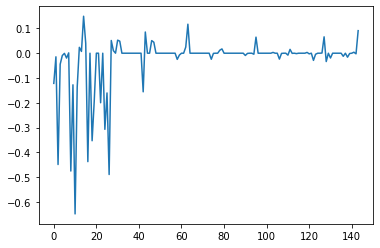

-----------------

### Below I invoke a second optimisation to calculate the Q_adj into the initial, rather than final, water masses. The optimisation below is not working yet... 


In [52]:
N = volumes.shape[-1]

nofaces = np.count_nonzero(cons_matrix)

Tmatrix1=np.zeros((N,int(nofaces)))
Smatrix1=np.zeros((N,int(nofaces)))
Tmatrix2=np.zeros((N,int(nofaces)))
Smatrix2=np.zeros((N,int(nofaces)))
Vmatrix2=np.zeros((N,int(nofaces)))

ix=0
for i in (range(N)):
    for j in range(N):
        if cons_matrix[i,j]>0:
            Tmatrix1[j,ix] = tracers[0,1,i] #vertex ix brings temp of WM i to WM j
            Smatrix1[j,ix] = tracers[0,0,i] #vertex ix brings temp of WM i to WM j
            # Tmatrix2[j,ix] = tracers[1,1,i] #vertex ix brings temp of WM i to WM j
            # Smatrix2[j,ix] = tracers[1,0,i] #vertex ix brings temp of WM i to WM j
            Vmatrix2[j,ix] = volumes[0,i]
            ix=ix+1

volumes_2 = np.concatenate((volumes[1,:], volumes[1,:])) # Shape: [2 x N]
tracers_2 = np.concatenate((tracers[1,1,:],tracers[1,0,:]))

A_T1 = np.zeros_like(Tmatrix1)
A_S1 = np.zeros_like(Tmatrix1)
for i in range(int(nofaces)):
    A_T1[:,i] = Tmatrix1[:,i]
    A_S1[:,i] = Smatrix1[:,i]

A1 = np.concatenate((A_T1,A_S1),axis=0)

# A_T2 = np.zeros_like(Tmatrix2)
# A_S2 = np.zeros_like(Tmatrix2)
# for i in range(int(nofaces)):
#     A_T2[:,i] = Tmatrix2[:,i]*weights[1,:]
#     A_S2[:,i] = Smatrix2[:,i]*weights[0,:]

# A2 = np.concatenate((A_T2,A_S2),axis=0)

Vmat2_T = np.zeros_like(Vmatrix2)
Vmat2_S = np.zeros_like(Vmatrix2)

for i in range(int(nofaces)):
    Vmat2_T[:,i] = Vmatrix2[:,i]*weights2[1,:]
    Vmat2_S[:,i] = Vmatrix2[:,i]*weights2[0,:]

Vmatrix2 = np.concatenate((Vmat2_T,Vmat2_S),axis=0)

## Invoke solver to calculate transports
u = A1.shape

x = cp.Variable(u)

cost = cp.sum_squares(x.flatten() * Vmatrix2.flatten())

constraints = [x@G == volumes_2*tracers_2 - A1@G]
prob = cp.Problem(cp.Minimize(cost), constraints)


# The optimal objective value is returned by prob.solve()`.
# OSQP, ECOS, ECOS_BB, MOSEK, CBC, CVXOPT, NAG, GUROBI, and SCS
result = prob.solve(verbose=True, solver=cp.MOSEK)

if prob.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % prob.value)
for variable in prob.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value))

# The optimal value for x is stored in `x.value`.
tracer_adj = variable.value

T_adj = np.zeros(N)
S_adj = np.zeros(N)
ix=0
for i in (range(N)):
    for j in range(N):
        if cons_matrix[i,j]>0:
            T_adj[i] = tracer_adj[j,ix] #vertex ix brings temp of WM i to WM j
            S_adj[i] = tracer_adj[j+N,ix] #vertex ix brings temp of WM i to WM j
            ix=ix+1



                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 15 01:11:42 PM: Your problem has 1990656 variables, 1 constraints, and 0 parameters.
(CVXPY) May 15 01:11:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 01:11:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 01:11:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 01:11:42 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 15 01:11:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

In [55]:
tracer_adj

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 1.39219943e-02, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  6.49085035e+08]])

In [ ]:
plt.plot(S_Av_adj)

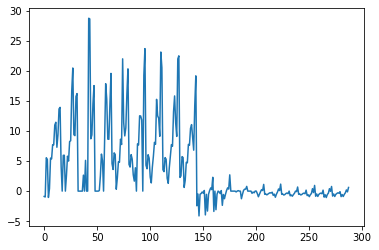

In [48]:
plt.plot(tracers_2[:])

26


In [31]:
A1@G

array([-3.04537474e+00, -1.19997635e-01,  3.73921490e-01,  1.52477406e-01,
       -3.00501358e-01,  7.52024617e+00,  4.63651808e-01,  4.76436019e+01,
        3.98572726e-01,  1.02099251e-01,  5.96317123e-01,  1.45732298e-01,
        7.80408528e+00,  8.32150464e+01,  1.46212166e+00,  5.02717206e+01,
        2.05089304e-04,  0.00000000e+00,  1.24117789e-03,  7.36164950e-05,
        0.00000000e+00,  7.99664004e+01,  6.75603761e-05,  9.39191212e+01,
        6.55226459e-03,  7.09619093e-04,  7.80225757e-02,  7.74847985e-02,
        1.38413248e-01,  1.85693959e+02,  6.56675343e+00,  3.56483096e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.50573851e+01,  0.00000000e+00,  6.48056584e+01,
        0.00000000e+00,  0.00000000e+00,  6.08662610e-01,  4.73537002e-01,
        3.83938918e+01,  8.93181916e+01,  3.83385217e+01,  6.17571660e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.56741477e-02,  

In [48]:
np.sqrt(np.nansum((tracer_adj.flatten()*Vmatrix2.flatten())**2))

337336735.3382054

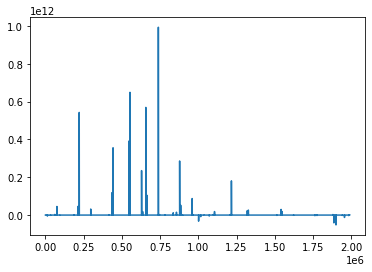

In [50]:
plt.plot(tracer_adj.flatten())

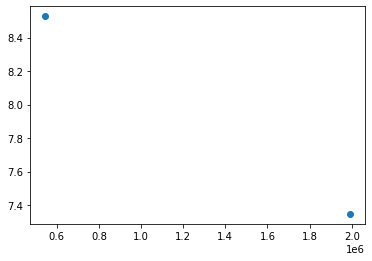

In [38]:
plt.plot(np.log10(tracer_adj.flatten()*Vmatrix2.flatten()), 'o')

In [39]:
Vmatrix2.flatten()

array([0.0871591 , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03423865])

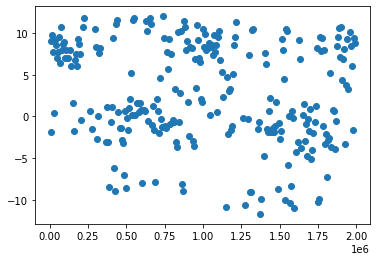

In [33]:
plt.plot(np.log10(abs(tracer_adj.flatten())), 'o')

#### Once the code above is fixed, it can be added to the MTM.py script so the function below can be called

In [49]:
# adj = MTM.optimise2(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights2, g_ij=G)
# T_adj = adj['Q_T']
# S_adj = adj['Q_S']
# adj_full = adj['Q_full']

In [54]:
N = volumes.shape[-1]

nofaces = np.count_nonzero(connected)

weight_T = np.zeros((N,int(nofaces)))
weight_S = np.zeros((N,int(nofaces)))

for i in range(int(nofaces)):
    weight_T[:,i] = weights2[1,:]
    weight_S[:,i] = weights2[0,:]

weights_combi = np.concatenate((weight_T, weight_S),axis=0)

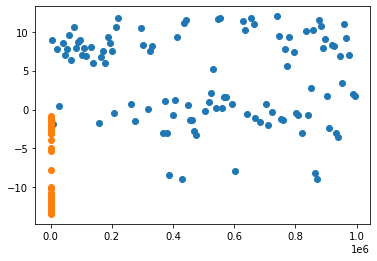

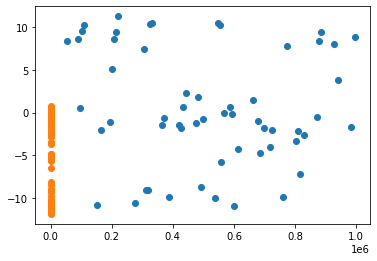

In [55]:
plt.plot(np.log10(tracer_adj[:144,:]).flatten(), 'o')
plt.plot(np.log10(dS_adj).flatten(), 'o')
plt.show()
plt.plot(np.log10(tracer_adj[144:,:]).flatten(), 'o')
plt.plot(np.log10(dT_adj).flatten(), 'o')
plt.show()




In [56]:
print(np.count_nonzero((tracer_adj[:144,:])))
print(np.count_nonzero((tracer_adj[:,:])))

128
255


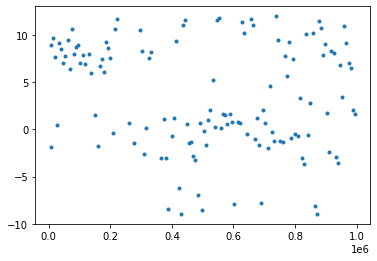

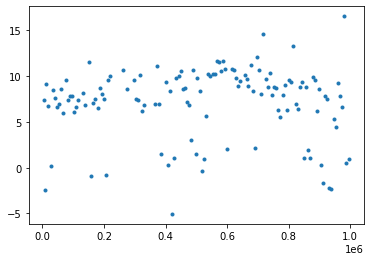

----------


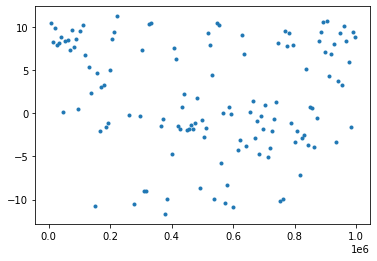

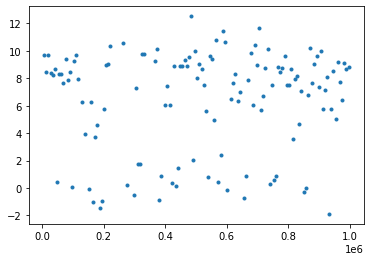

In [59]:
tracer_adj[tracer_adj == 0] = np.nan
plt.plot(np.log10(abs(tracer_adj[:144,:].flatten())), '.')
plt.show()
plt.plot(np.log10(abs(tracer_adj[:144,:].flatten()*weights_combi[:144,:].flatten())), '.')
plt.show()

print('----------')

plt.plot(np.log10(abs(tracer_adj[144:,:].flatten())), '.')
plt.show()
plt.plot(np.log10(abs(tracer_adj[144:,:].flatten()*weights_combi[144:,:].flatten())), '.')

# plt.ylim(-1e-6,1e-6)

In [74]:
N = volumes.shape[-1]

nofaces = np.count_nonzero(connected)

volume_flat = V_late.values.flatten()

vols_T = np.zeros((N,int(nofaces)))
vols_S = np.zeros((N,int(nofaces)))

for i in range(int(nofaces)):
    vols_T[:,i] = volume_flat
    vols_S[:,i] = volume_flat

vols_combi = np.concatenate((vols_T, vols_S),axis=0)

In [85]:
dhfds_adj = dT_adj*(Cp*rho*V_late.values.flatten()) # units: J
np.nansum(dhfds_adj)
print(np.nansum(dhfds_adj)) # 2e23
print(np.nansum(tracer_adj[:144,:].flatten()*vols_combi[:144,:].flatten()*(Cp*rho))) # 1e35

2.4661402045005806e+23
1.6452955825181906e+35


In [89]:
dwfo_adj = -dS_adj*(rho*V_late.values.flatten())/S0 # units: kg
print(np.nansum(dwfo_adj)*10**-15) # 2e15
print(np.nansum(tracer_adj[144:,:].flatten()*vols_combi[144:,:].flatten()*(Cp*rho))) # 1e34

2.4607556051202963
1.3773601491939598e+34


----------
## E) Save Output 

In [37]:
file_path = '../Optimisation_results/ACCESS_CM2_no_known_Q_prior_transports.nc'

In [38]:
import os
if os.path.exists(file_path):
   os.remove(file_path)
   print('File deleted')

da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

ds_BSP.to_netcdf(file_path, mode='w')
print('File saved')


File deleted
File saved
